In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

In [2]:
from helper_functions import  *

# PL 

In [6]:

def generate_PL(raw_prediction, min_len=40, max_len=2500):
    from functools import lru_cache

    df = pd.DataFrame( [ ( ac, len(raw_pred), any( x[2]>=40 for x in reg_list) )
                         for ac, raw_pred, reg_list in raw_prediction ]
                      , columns=["ac", "len", "dis"])
    df.set_index('ac', inplace=True)
    df = df[(df.len >= min_len) & (df.len<=2500)]
    
    @lru_cache(maxsize=None)
    def _PL(L):
        eps = round(0.1*L)
        return df[ (df.len >= L-eps) & (df.len <= L+eps) ].mean().dis
        
    _PL.df = df
    _PL.raw = df.groupby('len').mean()  # da bi kasnije mogao da se referisem na njega
    
    return _PL
  

In [7]:
import pickle

with open('data/predictions/vsl2b_valid.pickle', 'rb') as f:
    vsl2b_valid = pickle.load(f)
    PL = generate_PL(vsl2b_valid)

with open('data/predictions/vsl2b_random.pickle', 'rb') as fr:
    vsl2b_random = pickle.load(fr)
    PL_random = generate_PL(vsl2b_random)

with open('data/predictions/vsl2b_uniform.pickle', 'rb') as fu:
    vsl2b_uniform = pickle.load(fu)
    PL_uniform = generate_PL(vsl2b_uniform)

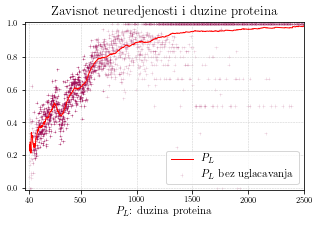

In [9]:
fig, ax = plt.subplots() 

xs = np.arange(40, 2500)
ys = np.array([PL(x) for x in xs])

plt.plot(xs, ys, 'r-', linewidth=1, label='$P_L$')

xs_count = PL.df.groupby('len').count().dis
xs_color = [(0.6,0,0.3, max(min(n/100,0.7),0.2) ) for n in xs_count]
plt.scatter( PL.raw.index,  PL.raw.dis, label='$P_L$ bez uglacavanja'
            , marker='+', color=xs_color, linewidth=0.5, s=10)

setFigSize(fig, 5)
ax.set_ylim(-0.01, 1.01)
ax.set_xlim(0, 2500)
ax.set_xticks([40]+list(range(0, 2501, 500))[1:])

ax.set_title('Zavisnot neuredjenosti i duzine proteina')
ax.set_xlabel("$P_L$: duzina proteina")

plt.legend()

plt.savefig('plots/PL_F.pdf')


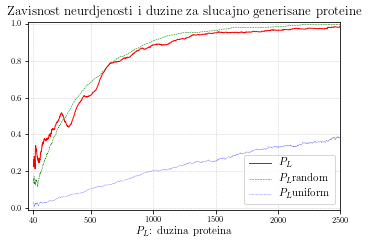

In [32]:
fig, ax = plt.subplots() 

xs = np.arange(40, 2500)
ys = np.array([PL(x) for x in xs])
ys_random = np.array([PL_random(x) for x in xs])
ys_uniform = np.array([PL_uniform(x) for x in xs])

plt.plot(xs, ys, 'r-', linewidth=1, label='$P_L$')
plt.plot(xs, ys_random, 'g--', linewidth=0.5, label='$P_L$random')
plt.plot(xs, ys_uniform, 'b:', linewidth=0.5, label='$P_L$uniform')

#setFigSize(fig, 10)
ax.set_ylim(-0.01, 1.01)
ax.set_xlim(0, 2500)
ax.set_xticks([40]+list(range(0, 2501, 500))[1:])

ax.set_title('Zavisnost neurdjenosti i duzine za slucajno generisane proteine')
ax.set_xlabel("$P_L$: duzina proteina")

plt.legend(loc='lower right' )

plt.savefig('plots/PL_F_cmp.pdf')
